##### Library Installation

In [1263]:
# uncomment this cell to install the following libraries.
# follow the below link to use gpu. prefer to use windows native (with tensorflow 2.10) because it is easier to install.
# https://www.tensorflow.org/install/pip
#%pip install numpy
#%pip install pandas
#%pip install ta
#%pip install matplotlib
#%pip install scikit-learn
#%pip install tensorflow
#%pip install ipympl

##### Imports

In [1264]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
import keras
from keras import layers
from keras import Input
from keras import Model
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

from ta import momentum
from ta import volume
from ta import volatility
from ta import trend


##### Miscellaneous

In [1265]:
# Used for interactive plots (zooming in)
%matplotlib widget

np.set_printoptions(threshold=np.inf, linewidth=300)

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Data acquisition method

##### Load from file (obtained through data extraction tool)

In [1266]:
def get_stock_data_and_period_csv(stock_ticker: str):
    df = pd.read_csv('ta_stock_data_' + stock_ticker + '.csv')

    start_date = df['Date'].iloc[0]
    end_date = df['Date'].iloc[-1]

    print('Time Period: ' + str(start_date) + ' to ' + str(end_date))

    return df, start_date, end_date

# Data Transform

In [1267]:
def add_technical_analysis(df: pd.DataFrame):
    # To add a new TA column, simply follow the examples shown. Some TA might have more than one function, such as MACD - it is not necessary to use them, but might as well have them!
    # Use the ta library documentation to find more indicators for each of the below categories.
    # Hover over the TA class to see what data is needed, for example: open, high, low, close, volume
    # Some TA classes needs a window, which you can optionally add as an argument.

    # Momentum
    df['rsi'] = momentum.RSIIndicator(df['Close'], window=10).rsi()
    df['awesome_oscillator'] = momentum.AwesomeOscillatorIndicator(df['High'], df['Low'], window1=5, window2=30).awesome_oscillator()

    # Volume
    df['force_index'] = volume.ForceIndexIndicator(df['Close'], df['Volume'], window=10).force_index()
    df['ease_of_movement'] = volume.EaseOfMovementIndicator(df['High'], df['Low'], df['Volume'], window=10).ease_of_movement()
    df['ease_of_movement_signal'] = volume.EaseOfMovementIndicator(df['High'], df['Low'], df['Volume'], window=10).sma_ease_of_movement()

    # Volatility
    df['bbands_upper'] = volatility.BollingerBands(df['Close'], window=10).bollinger_hband()
    df['bbands_middle'] = volatility.BollingerBands(df['Close'], window=10).bollinger_mavg()
    df['bbands_lower'] = volatility.BollingerBands(df['Close'], window=10).bollinger_lband()
    df['atr'] = volatility.AverageTrueRange(df['High'], df['Low'], df['Close'], window=10).average_true_range()

    # Trend
    df['macd'] = trend.MACD(df['Close'], window_slow=20, window_fast=10, window_sign=9).macd()
    df['macd_signal'] = trend.MACD(df['Close'], window_slow=20, window_fast=10, window_sign=9).macd_signal()
    df['aroon'] = trend.AroonIndicator(df['Close'], window=20).aroon_indicator()
    df['aroon_up'] = trend.AroonIndicator(df['Close'], window=20).aroon_up()
    df['aroon_down'] = trend.AroonIndicator(df['Close'], window=20).aroon_down()

    return df

In [1268]:
def dataframe_copy(df: pd.DataFrame):
    new = df.copy()
    return new

In [1269]:
def dataframe_clean(df: pd.DataFrame):
    df = df.dropna()
    df = df.drop(['Date'], axis=1)
    return df

In [1270]:
def dataframe_stats(df: pd.DataFrame):
    print(df.shape)
    print(df.columns)
    print(df.isnull().sum())

##### Preparing data for loading into model

In [1271]:
def set_column_as_first(df: pd.DataFrame, col_name: str):
    col_loc = df.columns.get_loc(col_name)
    if col_loc != 0:
        cols = list(df.columns)
        a, b = cols.index(col_name), cols.index(df.columns[0])
        cols[b], cols[a] = cols[a], cols[b]
        df = df[cols]
    
    return df

In [1272]:
# used for plotting purposes
def scaler_fit_column(df: pd.DataFrame, index: int = 0):
    scaler = MinMaxScaler(feature_range=(0, 1))   # fit to data, used by graphs to plot prices instead of values in the (0, 1) range
    scaler.fit(df[['Close']])

    return scaler

In [1273]:
def transform_data(df: pd.DataFrame):
    # Scale the data
    cols = df.columns

    scaler = MinMaxScaler(feature_range=(0, 1))
    df_scaled = scaler.fit_transform(df)    # fit and transform for all data
    df_scaled = pd.DataFrame(df_scaled)
    df_scaled.columns = cols

    return df_scaled

In [1274]:
def get_features_and_target(df: pd.DataFrame, target: str = 'Close'):
    df_features = df
    df_target = df[[target]]

    return df_features, df_target

##### Train Data Setup

In [1275]:
def setup_train_data(features: pd.DataFrame, target: pd.DataFrame, train_data_percent: float = 0.8):
    train_data_len = math.ceil(len(features.to_numpy()) * train_data_percent)

    train_x = features[0:train_data_len].to_numpy()
    train_y = target[0:train_data_len].to_numpy()

    return train_x, train_y, train_data_len


In [1276]:
def prepare_train_as_sliding_window(train_x, train_y, sliding_window_size: int = 5):
    x_train_sw = []
    y_train_sw = []

    # The sliding window size (in days) we use as input. There are 5 trading days in a week
    for i in range(sliding_window_size, len(train_x)):
        x_train_sw.append(train_x[i-sliding_window_size:i,:])
        y_train_sw.append(train_y[i:i+1, 0])

    x_train_sw, y_train_sw = np.array(x_train_sw), np.array(y_train_sw)   # convert to numpy array

    return x_train_sw, y_train_sw

In [1277]:
def setup_test_data(features, target, train_data_len):
    test_x = features[train_data_len:].to_numpy()
    test_y = target[train_data_len:].to_numpy()

    return test_x, test_y

In [1278]:
def prepare_test_as_sliding_window(test_x, test_y, sliding_window_size: int = 5):
    x_test_sw = []  # features
    y_test_sw = []  # target
    y_remaining = []    # features remaining

    for i in range(sliding_window_size, len(test_x)):
        x_test_sw.append(test_x[i-sliding_window_size:i,:])
        y_test_sw.append(test_y[i:i+1,0])
        y_remaining.append(test_x[i:i+1,1:])

    x_test_sw = np.array(x_test_sw)
    y_test_sw = np.array(y_test_sw)
    y_remaining = np.array(y_remaining)

    return x_test_sw, y_test_sw, y_remaining

# Transformer Model

In [1279]:
def transformer_encoder(
    inputs, 
    head_size, 
    num_heads, 
    ff_dim, 
    dropout=0.0
):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [1280]:
def build_model(    
    x_train_sw,
    sliding_window_size: int = 5,
    head_size=128,
    num_heads=16,
    ff_dim=16,
    num_transformer_blocks=16,
    mlp_units=[128],
    mlp_dropout=0.05,
    dropout=0.05,
):
    input_shape = x_train_sw.shape[1:]
    input_shape = (sliding_window_size, input_shape[1])
    inputs = Input(shape=input_shape)

    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1)(x)    # this tells us that the output is one prediction step.
    return Model(inputs, outputs)

##### Model Callbacks

In [1281]:
def get_model_callbacks():
    # Adding EarlyStopping callback (for lots of epochs)
    early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

    # Adding ModelCheckpoint callback
    # Define the path to save the best weights. The best weights will be used for stock prediction.
    checkpoint_path = 'best_weights.h5'
    checkpoint = ModelCheckpoint(checkpoint_path, save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min', verbose=1)

    model_callbacks = [early_stopping, checkpoint]

    return model_callbacks

##### Model Creation and Training

In [1282]:
def compile_model(model: Model, metrics=['mse', 'mae', 'mape'], learning_rate=0.0001):
    model.compile(
    loss="mean_squared_error",
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate), 
    metrics=metrics
    )

    return model

# General guidelines for hyperparameters
# - head_size and mlp_units should be large values (i.e. 256 for head_size and mlp_units, 8 num_heads, ff_dim, num_transformer_blocks)
# - you can't just keep increasing the hyperparameter values, memory is your constraint.

##### Model Fitting

In [1283]:
# train the model in a function here.
def train_model(model: Model, model_callbacks, x_train, y_train, train_validation_split: float = 0.8, epochs: int = 20, batch_size: int = 128):  
    # A higher train_validation_split value will mean more data is used for training, less for validation.
    history = model.fit(
                x_train,
                y_train,
                validation_split=1-train_validation_split,  # lil bug was hiding here
                epochs=epochs,
                batch_size=batch_size,
                callbacks=model_callbacks
            )

    # Load the best weights into the model
    model.load_weights('best_weights.h5')

    return model, history

##### Model Evaluation

In [1284]:
def evaluate_model(model: Model, x_test_sw, y_test_sw):
    model.evaluate(x_test_sw, y_test_sw, verbose=1)

##### Performing Prediction Steps

In [1285]:
# This function performs a single step prediction and adds supporting values from data for another prediction. Calling this multiple times resembles a multistep model.
# Prediction steps uses ground truth data (except target) per step.
def perform_prediction_step_on_ground_truth(model: Model, input_data, remaining_y):

    # reshape the input to (1, sliding_window_size, features)
    test_input = np.reshape(input_data, (1, input_data.shape[0], input_data.shape[1]))

    # perform a prediction step
    prediction_value = model.predict(test_input, verbose=0)
    last_gt_price = np.reshape(input_data[0][0], (1, 1))

    # concatenate the prediction value to beginning of the data columns
    final = np.concatenate((last_gt_price, remaining_y), axis=1)

    # concatenate the input data to the beginning of
    test_x = np.concatenate((input_data, final), axis=0)

    # shifting the sliding window one step forward
    test_x = test_x[1:]

    return test_x, prediction_value

In [1286]:
# This function performs a single step prediction without adding feature values. 
def perform_prediction_step_tomorrow(model: Model, input_data):
    test_input = np.reshape(input_data,(1,input_data.shape[0], input_data.shape[1]))
    prediction_value = model.predict(test_input)
    return prediction_value

In [1287]:
def perform_model_predictions(model, test_x, y_remaining):
    prediction_values = []
    new_test_x = test_x[0].copy()

    # Repeated single step prediction with the available data
    for i in range(y_remaining.shape[0]):
        new_test_x, prediction = perform_prediction_step_on_ground_truth(model, new_test_x, y_remaining[i])
        prediction_values.append(prediction)

    # Single step prediction into the future!
    prediction = perform_prediction_step_tomorrow(model, new_test_x)
    prediction_values.append(prediction)

    pred_vals = np.array(prediction_values)
    pred_vals = pred_vals.squeeze(1)

    return pred_vals

##### RMSE

In [1288]:
def calculate_rmse(actual_values, predicted_values):
    rmse = mean_squared_error(actual_values, predicted_values, squared=False)
    return rmse

# Graphs Output

#### Preparation for Output

In [1289]:
def prepare_x_axis_prediction_ground_truth(y_train_sw, y_test_sw, predicted_values): 
    # we are concatenating the train data in order to show predicted values on top of ground truth values. This includes the single prediction step into the future.
    predicted = np.concatenate((y_train_sw, predicted_values), axis=0)
    ground_truth = np.concatenate((y_train_sw, y_test_sw), axis=0)

    return predicted, ground_truth

#### Prediction vs Ground Truth Graph

In [1290]:
# TODO Fix plotting of the vertical line for test (something up with train_data_len...)

def plot_prediction_vs_gt(scaler: MinMaxScaler, predicted, ground_truth, start_date, end_date, train_data_len, train_validation_split):
    # Use the unscaled data to see prices
    scaler_pred = scaler.inverse_transform(predicted)
    scaler_ground_truth = scaler.inverse_transform(ground_truth)

    plt.figure(figsize=(15, 6))

    # Adding the predicted, ground truth, and tomorrow's prediction
    plt.plot(scaler_pred.flatten(), label='Next Trading Day Prediction', color='#0000FF')
    plt.plot(scaler_pred[:-1].flatten(), label='Predicted', color='#00FF00')
    plt.plot(scaler_ground_truth.flatten(), label='Ground Truth', color='#FF8800')

    # Adding vertical lines indicating different data usages
    plt.axvline(x=0, label='Train', color='#FF0000', ls=(0, (1, 4)))  # this data was used for model training by keras.
    plt.axvline(x=train_data_len * train_validation_split, label='Validation', color='#00FF00', ls=(0, (1, 4)))   # this data was used for model validation by keras.
    plt.axvline(x=train_data_len, label='Test', color='#0000FF', ls=(0, (1, 4)))   # this is the test data - predictions are made on it, and we can compare it to ground truth.
    handles, labels = plt.gca().get_legend_handles_labels()
    order = [1,2,0,3,4,5]

    plt.xlabel('Date (' + start_date + ' to ' + end_date + ') + 1')
    plt.ylabel('Stock Price ($)')
    plt.title('Prediction vs Ground Truth')
    plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order])
    plt.savefig('Prediction.png')
    plt.show()


#### Daily Closing Prices

In [1291]:
def plot_daily_close(df: pd.DataFrame, ticker: str):
    # Plotting daily closing prices
    plt.figure(figsize=(12, 6))
    plt.plot(df['Date'], df['Close'], linestyle='-')
    plt.xlabel('Date')
    plt.gca().set_xticklabels([])
    plt.xticks([])
    plt.ylabel('Closing Price')
    plt.title(ticker + ' Daily Closing Prices')
    plt.show()

#### Daily Stock Returns

In [1292]:
def plot_daily_returns(df: pd.DataFrame, ticker: str):
    df['Daily_Return'] = df['Close'].pct_change()
    df.dropna(inplace=True)

    plt.figure(figsize=(12, 6))

    # Plotting daily stock returns
    plt.plot(df['Date'][1:], df['Daily_Return'][1:], linestyle='-')
    plt.xlabel('Date')
    plt.gca().set_xticklabels([])
    plt.xticks([])
    plt.ylabel('Daily Return')
    plt.title(ticker + ' Daily Stock Return')
    plt.show()

#### Loss from Training and Validation

In [1293]:
def plot_loss_chart(history):
    # Accessing training and validation loss from the history object
    training_loss = history.history['loss']
    validation_loss = history.history['val_loss']

    # Generating a list of epochs (x-axis)
    epochs = range(1, len(training_loss) + 1)


    plt.figure(figsize=(8, 4))

    # Plotting the training and validation loss over iterations
    plt.plot(epochs, training_loss, label='Training Loss', linestyle='-')
    plt.plot(epochs, validation_loss, label='Validation Loss', linestyle='-')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

#### Pie charts

In [1294]:
def calculate_pie_chart_values(ground_truth, predicted, tolerance_percent: int = 2):
    # Getting data for pie chart
    pie_chart_data = pd.DataFrame({
        'Predicted': predicted[:-1].flatten(),  # remove last predicted 'future' value
        'Ground_Truth': ground_truth.flatten()
    })


    # Calculating all of the necessary things for the pie chart.

    # tolerance = ((pred - gt) / gt) * 100 < tolerance_percent  # determines if the model predicted under some tolerance percent
    # gt movement = gtcurr - gtprev > 0                         # determines if the ground truth movement was up or down
    # pred movement = pred - gtprev > 0                         # determines if the model prediction was up or down
    # if the gt movement and prediction movement are both T or F, then the model predicted correctly upwards/downards.
    # if the gt movement and prediction movement are T/F or F/T, then the model predicted incorrectly downwards for T/F and incorrectly upwards for F/T
    # if the tolerance is under the %, then the model predicted accurately.
    # if the tolerance is over the %, then the model predicted inaccurately.

    predicted_values = np.array(pie_chart_data['Predicted'])
    ground_truth_values = np.array(pie_chart_data['Ground_Truth'])

    #tolerance_percent = 2   # integer used to determine if the model was accurate or not. 1 = 1% tolerance
    tolerance = []
    ground_truth_movement = []  # T is up, F is down
    prediction_movement = []    # T is up, F is down

    # append bool values to each array based on the requirements
    for i in range(1, ground_truth_values.size):
        tolerance.append(True if abs((predicted_values[i] - ground_truth_values[i]) / ground_truth_values[i]) * 100 < tolerance_percent else False)
        ground_truth_movement.append(True if ground_truth_values[i] - ground_truth_values[i-1] > 0 else False)
        prediction_movement.append(True if predicted_values[i] - ground_truth_values[i-1] > 0 else False)



    # Categorizations of model movement prediction, ground truth movement, and tolerance 
    correct = 0
    incorrect = 0
    under = 0
    over = 0

    correct_upwards_under = 0
    correct_upwards_over = 0
    correct_downwards_under = 0
    correct_downwards_over = 0
    incorrect_upwards_under = 0
    incorrect_upwards_over = 0
    incorrect_downwards_under = 0
    incorrect_downwards_over = 0



    # TODO research a cleaner way of doing this...
    for i in range(0, ground_truth_values.size - 1):
        correct += int((ground_truth_movement[i] == True and prediction_movement[i] == True) or (ground_truth_movement[i] == False and prediction_movement[i] == False))     # model predicted correct direction
        incorrect += int((ground_truth_movement[i] == True and prediction_movement[i] == False) or (ground_truth_movement[i] == False and prediction_movement[i] == True))  # model predicted wrong direction
        under += int(tolerance[i] == True)  # model predicted under tolerance
        over += int(tolerance[i] == False)  # model predicted over tolerance

        correct_upwards_under += int(ground_truth_movement[i] == True and prediction_movement[i] == True and tolerance[i] == True)         # model predicted correctly upwards under tolerance
        correct_upwards_over += int(ground_truth_movement[i] == True and prediction_movement[i] == True and tolerance[i] == False)         # model predicted correctly updwards over tolerance
        correct_downwards_under += int(ground_truth_movement[i] == False and prediction_movement[i] == False and tolerance[i] == True)     # model predicted correctly downwards under tolerance
        correct_downwards_over += int(ground_truth_movement[i] == False and prediction_movement[i] == False and tolerance[i] == False)     # model predicted correctly downwards over tolerance
        incorrect_upwards_under += int(ground_truth_movement[i] == False and prediction_movement[i] == True and tolerance[i] == True)      # model predicted incorrectly upwards under tolerance
        incorrect_upwards_over += int(ground_truth_movement[i] == False and prediction_movement[i] == True and tolerance[i] == False)      # model predicted incorrectly upwards over tolerance
        incorrect_downwards_under += int(ground_truth_movement[i] == True and prediction_movement[i] == False and tolerance[i] == True)    # model predicted incorrectly downwards under tolerance
        incorrect_downwards_over += int(ground_truth_movement[i] == True and prediction_movement[i] == False and tolerance[i] == False)    # model predicted incorrectly downwards over tolerance

    tol_per = str(tolerance_percent)
    print('Number of times the model predicted CORRECT direction: ' + str(correct))
    print('Number of times the model predicted INCORRECT direction: ' + str(incorrect))
    print('Number of times the model predicted UNDER ' + tol_per + '% tolerance: ' + str(under))
    print('Number of times the model predicted OVER ' + tol_per + '% tolerance: ' + str(over))

    print('Number of times the model CORRECTLY predicted UPWARD movement UNDER ' + tol_per + '% tolerance: ' + str(correct_upwards_under))
    print('Number of times the model CORRECTLY predicted UPWARD movement OVER ' + tol_per + '% tolerance: ' + str(correct_upwards_over))
    print('Number of times the model CORRECTLY predicted DOWNWARD movement UNDER ' + tol_per + '% tolerance: ' + str(correct_downwards_under))
    print('Number of times the model CORRECTLY predicted DOWNWARD movement OVER ' + tol_per + '% tolerance: ' + str(correct_downwards_over))
    print('Number of times the model INCORRECTLY predicted UPWARD movement UNDER ' + tol_per + '% tolerance: ' + str(incorrect_upwards_under))
    print('Number of times the model INCORRECTLY predicted UPWARD movement OVER ' + tol_per + '% tolerance: ' + str(incorrect_upwards_over))
    print('Number of times the model INCORRECTLY predicted DOWNWARD movement UNDER ' + tol_per + '% tolerance: ' + str(incorrect_downwards_under))
    print('Number of times the model INCORRECTLY predicted DOWNWARD movement OVER ' + tol_per + '% tolerance: ' + str(incorrect_downwards_over))

    # big tuple idk how else to do it...
    return (correct, incorrect, under, over, 
        correct_upwards_under, correct_upwards_over, correct_downwards_under, correct_downwards_over, 
        incorrect_upwards_under, incorrect_upwards_over, incorrect_downwards_under, incorrect_downwards_over)

In [1295]:
# Helper function to remove zero-percent percentages from the pie chart
def auto_percent(pct):
    return ('%1.1f%%' % pct) if pct > 0 else ''

In [1296]:
# Data for the pie chart. Use any of these to sort the data by their respective values.

def plot_pie_categories(tolerance_percent, correct_upwards_under, correct_downwards_under, incorrect_upwards_under, incorrect_downwards_under, correct_upwards_over, correct_downwards_over, incorrect_upwards_over, incorrect_downwards_over):
    # the below are only used for plot_pie_categories
    #labels_correctness = ['Correct Upwards Under', 'Correct Upwards Over', 'Correct Downwards Under', 'Correct Downwards Over', 'Incorrect Upwards Under', 'Incorrect Upwards Over', 'Incorrect Downwards Under', 'Incorrect Downwards Over']
    #sizes_correctness = [correct_upwards_under, correct_upwards_over, correct_downwards_under, correct_downwards_over, incorrect_upwards_under, incorrect_upwards_over, incorrect_downwards_under, incorrect_downwards_over]
    labels_tolerance = ['Correct Upwards Under', 'Correct Downwards Under', 'Incorrect Upwards Under', 'Incorrect Downwards Under', 'Correct Upwards Over', 'Correct Downwards Over', 'Incorrect Upwards Over', 'Incorrect Downwards Over']
    sizes_tolerance = [correct_upwards_under, correct_downwards_under, incorrect_upwards_under, incorrect_downwards_under, correct_upwards_over, correct_downwards_over, incorrect_upwards_over, incorrect_downwards_over]

    colors = ['#00FF00', '#00AA00', '#FFFF00', '#AAAA44', '#00FFFF', '#008B8B', '#FF0000', '#880000']

    plt.figure(figsize=(12, 6))

    # Create the pie chart
    plt.pie(sizes_tolerance, labels=labels_tolerance, labeldistance=None, autopct=auto_percent, startangle=0, colors=colors)
    plt.legend(labels_tolerance, loc='best', bbox_to_anchor=(1.05, 1))
    plt.title('Model Correctness-Directionality-Tolerance Summary (' + str(tolerance_percent) + '% tolerance)')
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()

In [1297]:
def plot_pie_correctness(correct: int, incorrect: int):
    colors=['#00FF00', '#FF0000']
    correctness = [correct, incorrect]
    correctness_labels = ['Correct', 'Incorrect']

    plt.figure(figsize=(12, 6))
    plt.pie(correctness, labels=['Correct', 'incorrect'], labeldistance=None, autopct=auto_percent, startangle=0, colors=colors)
    plt.legend(correctness_labels, loc='best', bbox_to_anchor=(1.05, 1))
    plt.title('Model Correctness (Directionality)')
    plt.axis('equal')
    plt.show()

In [1298]:
def plot_pie_tolerance(tolerance_percent: int, under: int, over: int):
    colors=['#00FF00', '#FF0000']
    under_over = [under, over]
    under_over_labels = ['Under', 'Over']

    plt.figure(figsize=(12, 6))
    plt.pie(under_over, labels=under_over_labels, labeldistance=None, autopct=auto_percent, startangle=0, colors=colors)
    plt.legend(under_over_labels, loc='best', bbox_to_anchor=(1.05, 1))
    plt.title('Model Tolerance (%' + str(tolerance_percent) + ')')
    plt.axis('equal')
    plt.show()

# The entire program

In [1299]:
ticker = 'AMZN'

df, start_date, end_date = get_stock_data_and_period_csv(ticker)

df

Time Period: 2013-09-25 to 2023-09-22


,Date,Open,High,Low,Close,Volume
0,2013-09-25,15.7265,15.8355,15.5375,15.6325,40172000
1,2013-09-26,15.6950,15.9685,15.6630,15.9060,39798000
2,2013-09-27,15.8460,15.8605,15.6675,15.8005,33150000
3,2013-09-30,15.6705,15.7655,15.5530,15.6320,32472000
4,2013-10-01,15.7110,16.0500,15.6825,16.0475,47928000
...,...,...,...,...,...,...
2511,2023-09-18,140.4800,141.7500,139.2200,139.9800,42823500
2512,2023-09-19,138.7000,138.8400,135.5600,137.6300,61482500
2513,2023-09-20,138.5500,139.3700,135.2000,135.2900,46263700
2514,2023-09-21,131.9400,132.2400,129.3100,129.3300,70234800


In [1300]:
df = add_technical_analysis(df)

df

,Date,Open,High,Low,Close,Volume,rsi,awesome_oscillator,force_index,ease_of_movement,ease_of_movement_signal,bbands_upper,bbands_middle,bbands_lower,atr,macd,macd_signal,aroon,aroon_up,aroon_down
0,2013-09-25,15.7265,15.8355,15.5375,15.6325,40172000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN
1,2013-09-26,15.6950,15.9685,15.6630,15.9060,39798000,NaN,NaN,NaN,0.099216,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN
2,2013-09-27,15.8460,15.8605,15.6675,15.8005,33150000,NaN,NaN,NaN,-0.030129,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN
3,2013-09-30,15.6705,15.7655,15.5530,15.6320,32472000,NaN,NaN,NaN,-0.068549,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN
4,2013-10-01,15.7110,16.0500,15.6825,16.0475,47928000,NaN,NaN,NaN,0.158722,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2511,2023-09-18,140.4800,141.7500,139.2200,139.9800,42823500,53.326832,4.824500,-2.998809e+07,-7.946221,2.523703,146.394758,140.298,134.201242,3.311381,1.699448,1.468130,65.0,85.0,20.0
2512,2023-09-19,138.7000,138.8400,135.5600,137.6300,61482500,46.902396,4.021667,-5.080550e+07,-17.524987,1.555668,146.362686,140.334,134.305314,3.422242,1.298399,1.434184,65.0,80.0,15.0
2513,2023-09-20,138.5500,139.3700,135.2000,135.2900,46263700,41.386082,2.971833,-6.125124e+07,0.766151,2.162419,146.378889,140.327,134.275111,3.497018,0.776439,1.302635,65.0,75.0,10.0
2514,2023-09-21,131.9400,132.2400,129.3100,129.3300,70234800,31.050937,0.510333,-1.262236e+08,-27.157905,-0.116568,148.399188,139.475,130.550812,3.745316,-0.139409,1.014226,-30.0,70.0,100.0


In [1301]:
df_copy = dataframe_copy(df)
df = dataframe_clean(df)
dataframe_stats(df)

df

(2487, 19)
Index(['Open', 'High', 'Low', 'Close', 'Volume', 'rsi', 'awesome_oscillator',
       'force_index', 'ease_of_movement', 'ease_of_movement_signal',
       'bbands_upper', 'bbands_middle', 'bbands_lower', 'atr', 'macd',
       'macd_signal', 'aroon', 'aroon_up', 'aroon_down'],
      dtype='object')
Open                       0
High                       0
Low                        0
Close                      0
Volume                     0
rsi                        0
awesome_oscillator         0
force_index                0
ease_of_movement           0
ease_of_movement_signal    0
bbands_upper               0
bbands_middle              0
bbands_lower               0
atr                        0
macd                       0
macd_signal                0
aroon                      0
aroon_up                   0
aroon_down                 0
dtype: int64


,Open,High,Low,Close,Volume,rsi,awesome_oscillator,force_index,ease_of_movement,ease_of_movement_signal,bbands_upper,bbands_middle,bbands_lower,atr,macd,macd_signal,aroon,aroon_up,aroon_down
29,17.8390,18.0085,17.742,17.9445,40142000,68.610667,1.647633,1.739838e+07,-0.006473,0.024615,18.996663,17.72480,16.452937,0.437056,0.557406,0.491387,80.0,85.0,5.0
30,18.0225,18.1435,17.725,17.8090,45646000,64.658935,1.541308,1.311049e+07,0.054093,0.041932,18.746333,17.87190,16.997467,0.435201,0.519610,0.497032,75.0,80.0,5.0
31,17.7930,17.8950,17.094,17.1780,84926000,49.813564,1.359250,9.834321e+05,-0.414761,-0.001812,18.483535,17.92865,17.373765,0.471780,0.428001,0.483226,60.0,75.0,15.0
32,17.2975,17.5525,17.202,17.5155,53138000,55.839181,1.171575,4.065367e+06,-0.077338,-0.060035,18.442786,17.86325,17.283714,0.462052,0.381997,0.462980,60.0,70.0,10.0
33,17.5295,17.7685,17.403,17.7190,45234000,59.126944,1.047508,4.999868e+06,0.168472,-0.042167,18.429120,17.84435,17.259580,0.452397,0.358945,0.442173,60.0,65.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2511,140.4800,141.7500,139.220,139.9800,42823500,53.326832,4.824500,-2.998809e+07,-7.946221,2.523703,146.394758,140.29800,134.201242,3.311381,1.699448,1.468130,65.0,85.0,20.0
2512,138.7000,138.8400,135.560,137.6300,61482500,46.902396,4.021667,-5.080550e+07,-17.524987,1.555668,146.362686,140.33400,134.305314,3.422242,1.298399,1.434184,65.0,80.0,15.0
2513,138.5500,139.3700,135.200,135.2900,46263700,41.386082,2.971833,-6.125124e+07,0.766151,2.162419,146.378889,140.32700,134.275111,3.497018,0.776439,1.302635,65.0,75.0,10.0
2514,131.9400,132.2400,129.310,129.3300,70234800,31.050937,0.510333,-1.262236e+08,-27.157905,-0.116568,148.399188,139.47500,130.550812,3.745316,-0.139409,1.014226,-30.0,70.0,100.0


In [1302]:
df = set_column_as_first(df, 'Close')

df

,Close,High,Low,Open,Volume,rsi,awesome_oscillator,force_index,ease_of_movement,ease_of_movement_signal,bbands_upper,bbands_middle,bbands_lower,atr,macd,macd_signal,aroon,aroon_up,aroon_down
29,17.9445,18.0085,17.742,17.8390,40142000,68.610667,1.647633,1.739838e+07,-0.006473,0.024615,18.996663,17.72480,16.452937,0.437056,0.557406,0.491387,80.0,85.0,5.0
30,17.8090,18.1435,17.725,18.0225,45646000,64.658935,1.541308,1.311049e+07,0.054093,0.041932,18.746333,17.87190,16.997467,0.435201,0.519610,0.497032,75.0,80.0,5.0
31,17.1780,17.8950,17.094,17.7930,84926000,49.813564,1.359250,9.834321e+05,-0.414761,-0.001812,18.483535,17.92865,17.373765,0.471780,0.428001,0.483226,60.0,75.0,15.0
32,17.5155,17.5525,17.202,17.2975,53138000,55.839181,1.171575,4.065367e+06,-0.077338,-0.060035,18.442786,17.86325,17.283714,0.462052,0.381997,0.462980,60.0,70.0,10.0
33,17.7190,17.7685,17.403,17.5295,45234000,59.126944,1.047508,4.999868e+06,0.168472,-0.042167,18.429120,17.84435,17.259580,0.452397,0.358945,0.442173,60.0,65.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2511,139.9800,141.7500,139.220,140.4800,42823500,53.326832,4.824500,-2.998809e+07,-7.946221,2.523703,146.394758,140.29800,134.201242,3.311381,1.699448,1.468130,65.0,85.0,20.0
2512,137.6300,138.8400,135.560,138.7000,61482500,46.902396,4.021667,-5.080550e+07,-17.524987,1.555668,146.362686,140.33400,134.305314,3.422242,1.298399,1.434184,65.0,80.0,15.0
2513,135.2900,139.3700,135.200,138.5500,46263700,41.386082,2.971833,-6.125124e+07,0.766151,2.162419,146.378889,140.32700,134.275111,3.497018,0.776439,1.302635,65.0,75.0,10.0
2514,129.3300,132.2400,129.310,131.9400,70234800,31.050937,0.510333,-1.262236e+08,-27.157905,-0.116568,148.399188,139.47500,130.550812,3.745316,-0.139409,1.014226,-30.0,70.0,100.0


In [1303]:
scaler = scaler_fit_column(df, index=0)
df = transform_data(df)

df

,Close,High,Low,Open,Volume,rsi,awesome_oscillator,force_index,ease_of_movement,ease_of_movement_signal,bbands_upper,bbands_middle,bbands_lower,atr,macd,macd_signal,aroon,aroon_up,aroon_down
0,0.020886,0.020028,0.020757,0.020921,0.049002,0.688932,0.645302,0.685427,0.484850,0.577921,0.022010,0.018012,0.017919,0.019088,0.639886,0.650436,0.921053,0.842105,0.000000
1,0.020099,0.020803,0.020658,0.021982,0.060980,0.637029,0.643210,0.682521,0.485361,0.578402,0.020600,0.018884,0.021241,0.018843,0.637737,0.650819,0.894737,0.789474,0.000000
2,0.016435,0.019376,0.016960,0.020656,0.146465,0.442045,0.639627,0.674301,0.481407,0.577189,0.019120,0.019221,0.023538,0.023669,0.632528,0.649883,0.815789,0.736842,0.105263
3,0.018395,0.017409,0.017593,0.017791,0.077285,0.521188,0.635934,0.676390,0.484253,0.575575,0.018891,0.018833,0.022988,0.022385,0.629913,0.648510,0.815789,0.684211,0.052632
4,0.019576,0.018650,0.018771,0.019132,0.060083,0.564370,0.633493,0.677024,0.486326,0.576070,0.018814,0.018721,0.022841,0.021112,0.628602,0.647099,0.815789,0.631579,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2482,0.729476,0.730643,0.732656,0.729911,0.054837,0.488190,0.707812,0.653309,0.417884,0.647193,0.739401,0.745073,0.736429,0.398248,0.704818,0.716669,0.842105,0.842105,0.157895
2483,0.715831,0.713931,0.711207,0.719621,0.095445,0.403809,0.692015,0.639199,0.337094,0.620361,0.739221,0.745287,0.737064,0.412872,0.682016,0.714367,0.842105,0.789474,0.105263
2484,0.702244,0.716975,0.709097,0.718754,0.062324,0.331356,0.671358,0.632119,0.491367,0.637179,0.739312,0.745245,0.736880,0.422735,0.652339,0.705447,0.842105,0.736842,0.052632
2485,0.667637,0.676029,0.674580,0.680541,0.114492,0.195611,0.622923,0.588081,0.255847,0.574008,0.750688,0.740191,0.714154,0.455489,0.600268,0.685890,0.342105,0.684211,1.000000


In [1304]:
features, target = get_features_and_target(df, 'Close')

print(features.shape)
print(target.shape)

train_data_percent = 0.8
train_validation_split = 0.8
sliding_window_size = 5
tolerance_percent = 2

(2487, 19)
(2487, 1)


In [1305]:
features

,Close,High,Low,Open,Volume,rsi,awesome_oscillator,force_index,ease_of_movement,ease_of_movement_signal,bbands_upper,bbands_middle,bbands_lower,atr,macd,macd_signal,aroon,aroon_up,aroon_down
0,0.020886,0.020028,0.020757,0.020921,0.049002,0.688932,0.645302,0.685427,0.484850,0.577921,0.022010,0.018012,0.017919,0.019088,0.639886,0.650436,0.921053,0.842105,0.000000
1,0.020099,0.020803,0.020658,0.021982,0.060980,0.637029,0.643210,0.682521,0.485361,0.578402,0.020600,0.018884,0.021241,0.018843,0.637737,0.650819,0.894737,0.789474,0.000000
2,0.016435,0.019376,0.016960,0.020656,0.146465,0.442045,0.639627,0.674301,0.481407,0.577189,0.019120,0.019221,0.023538,0.023669,0.632528,0.649883,0.815789,0.736842,0.105263
3,0.018395,0.017409,0.017593,0.017791,0.077285,0.521188,0.635934,0.676390,0.484253,0.575575,0.018891,0.018833,0.022988,0.022385,0.629913,0.648510,0.815789,0.684211,0.052632
4,0.019576,0.018650,0.018771,0.019132,0.060083,0.564370,0.633493,0.677024,0.486326,0.576070,0.018814,0.018721,0.022841,0.021112,0.628602,0.647099,0.815789,0.631579,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2482,0.729476,0.730643,0.732656,0.729911,0.054837,0.488190,0.707812,0.653309,0.417884,0.647193,0.739401,0.745073,0.736429,0.398248,0.704818,0.716669,0.842105,0.842105,0.157895
2483,0.715831,0.713931,0.711207,0.719621,0.095445,0.403809,0.692015,0.639199,0.337094,0.620361,0.739221,0.745287,0.737064,0.412872,0.682016,0.714367,0.842105,0.789474,0.105263
2484,0.702244,0.716975,0.709097,0.718754,0.062324,0.331356,0.671358,0.632119,0.491367,0.637179,0.739312,0.745245,0.736880,0.422735,0.652339,0.705447,0.842105,0.736842,0.052632
2485,0.667637,0.676029,0.674580,0.680541,0.114492,0.195611,0.622923,0.588081,0.255847,0.574008,0.750688,0.740191,0.714154,0.455489,0.600268,0.685890,0.342105,0.684211,1.000000


In [1306]:
target

,Close
0,0.020886
1,0.020099
2,0.016435
3,0.018395
4,0.019576
...,...
2482,0.729476
2483,0.715831
2484,0.702244
2485,0.667637


In [1307]:
train_x, train_y, train_data_len = setup_train_data(features, target, train_data_percent)
x_train_sw, y_train_sw = prepare_train_as_sliding_window(train_x, train_y, sliding_window_size)

print(train_x.shape)
print(train_y.shape)
print(x_train_sw.shape)
print(y_train_sw.shape)

(1990, 19)
(1990, 1)
(1985, 5, 19)
(1985, 1)


In [1308]:
test_x, test_y = setup_test_data(features, target, train_data_len)
x_test_sw, y_test_sw, y_remaining = prepare_test_as_sliding_window(test_x, test_y, sliding_window_size)

print(test_x.shape)
print(test_y.shape)
print(x_test_sw.shape)
print(y_test_sw.shape)
print(y_remaining.shape)

(497, 19)
(497, 1)
(492, 5, 19)
(492, 1)
(492, 1, 18)


In [1309]:
model = build_model(
    x_train_sw, 
    sliding_window_size,
    head_size=512,
    num_heads=16, 
    ff_dim=8, 
    num_transformer_blocks=8, 
    mlp_units=[512], 
    mlp_dropout=0.05, 
    dropout=0.05
    )
model = compile_model(model)

model, history = train_model(model, get_model_callbacks(), x_train_sw, y_train_sw, train_validation_split, epochs=50, batch_size=128)
evaluate_model(model, x_test_sw, y_test_sw)

Epoch 1/50
13/13 [==============================] - ETA: 0s - loss: 0.0145 - mse: 0.0145 - mae: 0.0893 - mape: 88442.6328
Epoch 1: val_loss improved from inf to 0.04715, saving model to best_weights.h5
13/13 [==============================] - 10s 235ms/step - loss: 0.0145 - mse: 0.0145 - mae: 0.0893 - mape: 88442.6328 - val_loss: 0.0471 - val_mse: 0.0471 - val_mae: 0.2053 - val_mape: 24.6952
Epoch 2/50
13/13 [==============================] - ETA: 0s - loss: 0.0036 - mse: 0.0036 - mae: 0.0460 - mape: 9078.7539
Epoch 2: val_loss improved from 0.04715 to 0.01893, saving model to best_weights.h5
13/13 [==============================] - 2s 166ms/step - loss: 0.0036 - mse: 0.0036 - mae: 0.0460 - mape: 9078.7539 - val_loss: 0.0189 - val_mse: 0.0189 - val_mae: 0.1283 - val_mape: 15.5395
Epoch 3/50
13/13 [==============================] - ETA: 0s - loss: 0.0027 - mse: 0.0027 - mae: 0.0385 - mape: 9284.8125
Epoch 3: val_loss did not improve from 0.01893
13/13 [==============================] - 

In [1310]:
predicted_values = perform_model_predictions(model, x_test_sw, y_remaining)
calculate_rmse(y_test_sw, predicted_values[:-1])

1/1 [==============================] - 0s 29ms/step


0.0784942541742009

In [1311]:
predicted_x_axis, ground_truth_x_axis = prepare_x_axis_prediction_ground_truth(y_train_sw, y_test_sw, predicted_values)

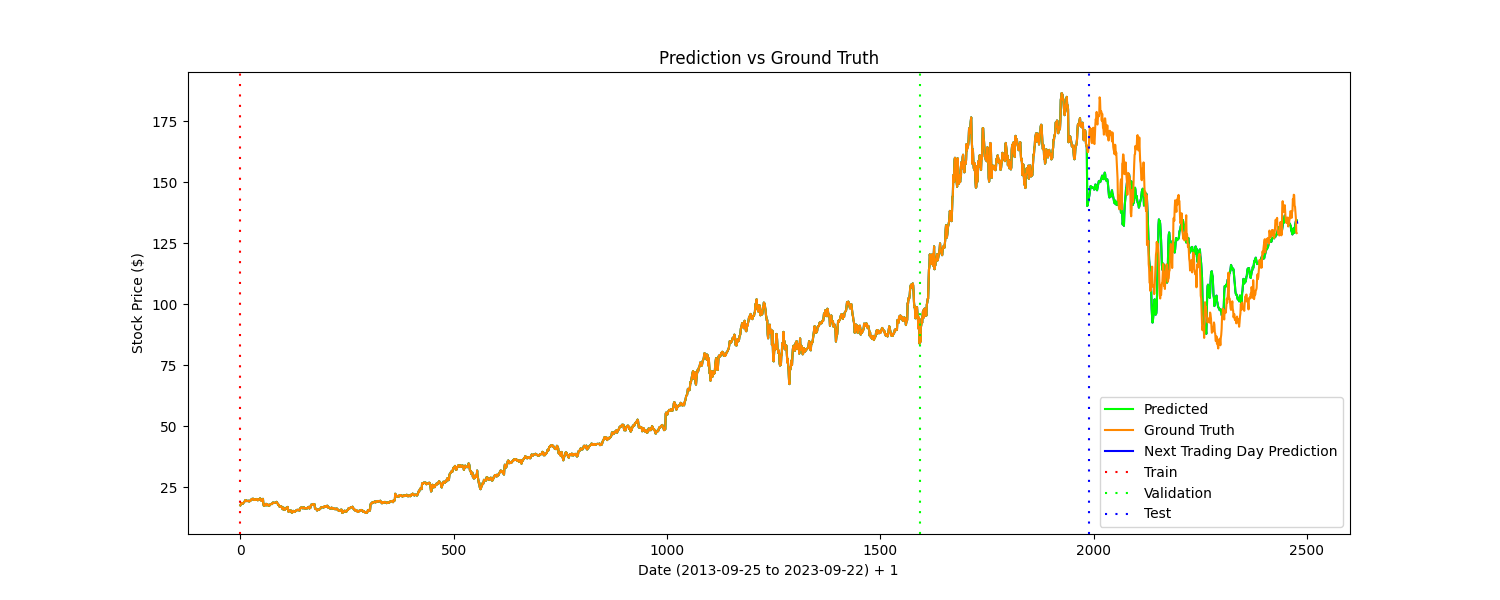

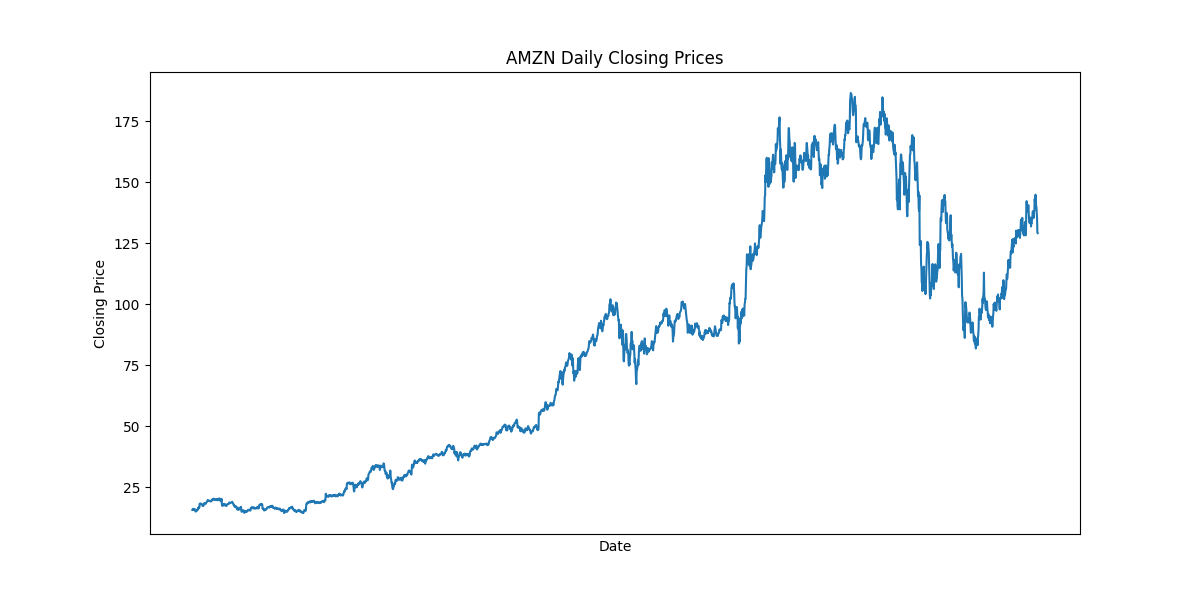

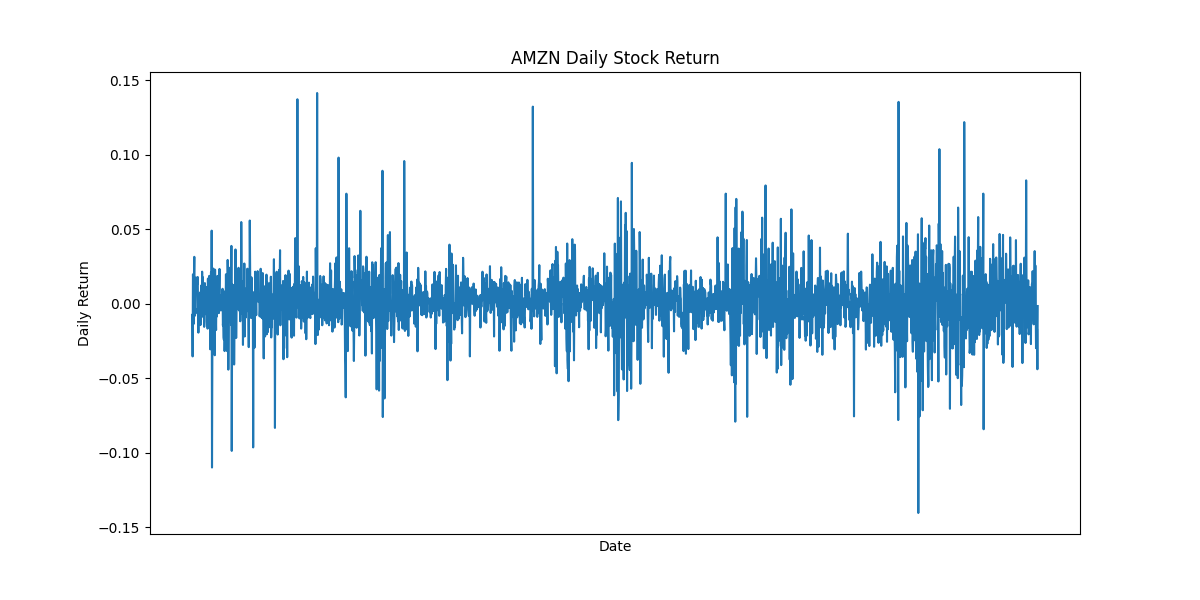

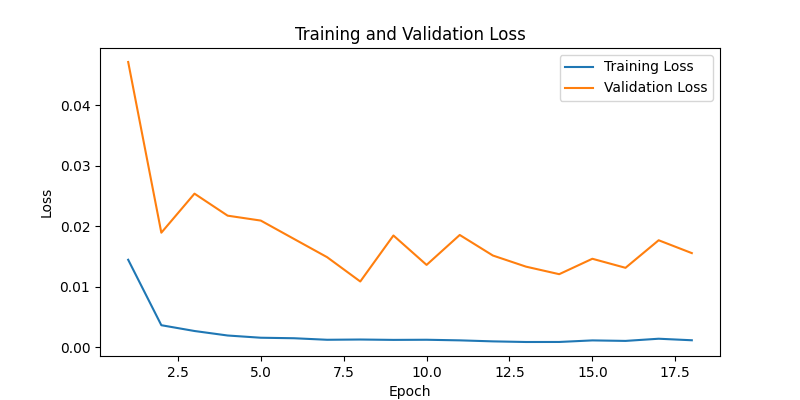

Number of times the model predicted CORRECT direction: 267
Number of times the model predicted INCORRECT direction: 224
Number of times the model predicted UNDER 2% tolerance: 79
Number of times the model predicted OVER 2% tolerance: 412
Number of times the model CORRECTLY predicted UPWARD movement UNDER 2% tolerance: 29
Number of times the model CORRECTLY predicted UPWARD movement OVER 2% tolerance: 99
Number of times the model CORRECTLY predicted DOWNWARD movement UNDER 2% tolerance: 37
Number of times the model CORRECTLY predicted DOWNWARD movement OVER 2% tolerance: 102
Number of times the model INCORRECTLY predicted UPWARD movement UNDER 2% tolerance: 4
Number of times the model INCORRECTLY predicted UPWARD movement OVER 2% tolerance: 106
Number of times the model INCORRECTLY predicted DOWNWARD movement UNDER 2% tolerance: 9
Number of times the model INCORRECTLY predicted DOWNWARD movement OVER 2% tolerance: 105


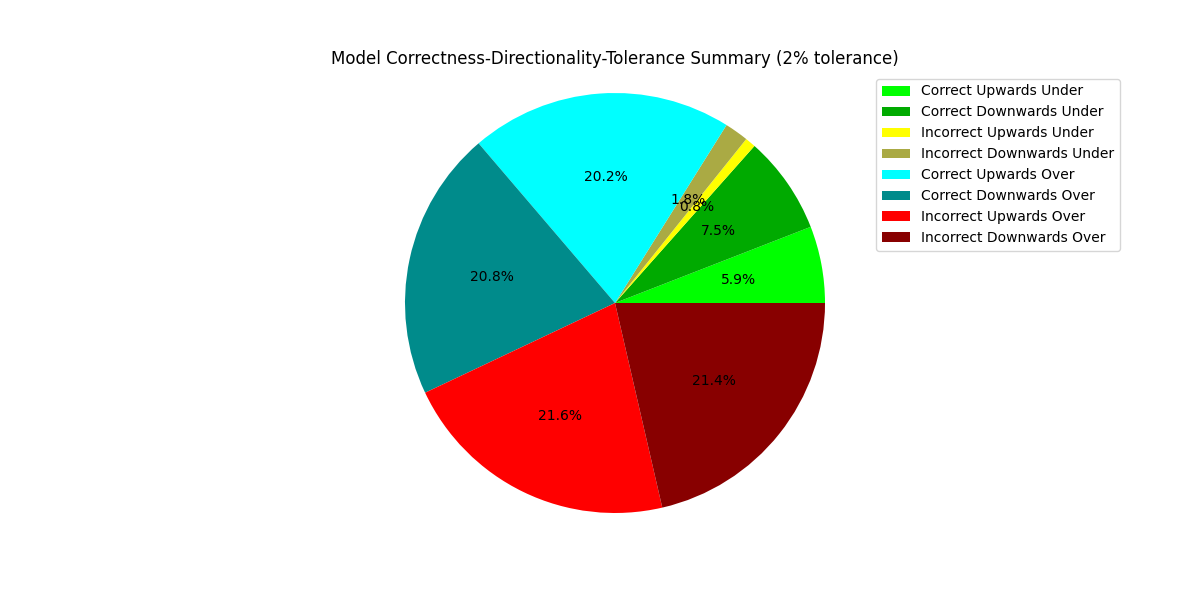

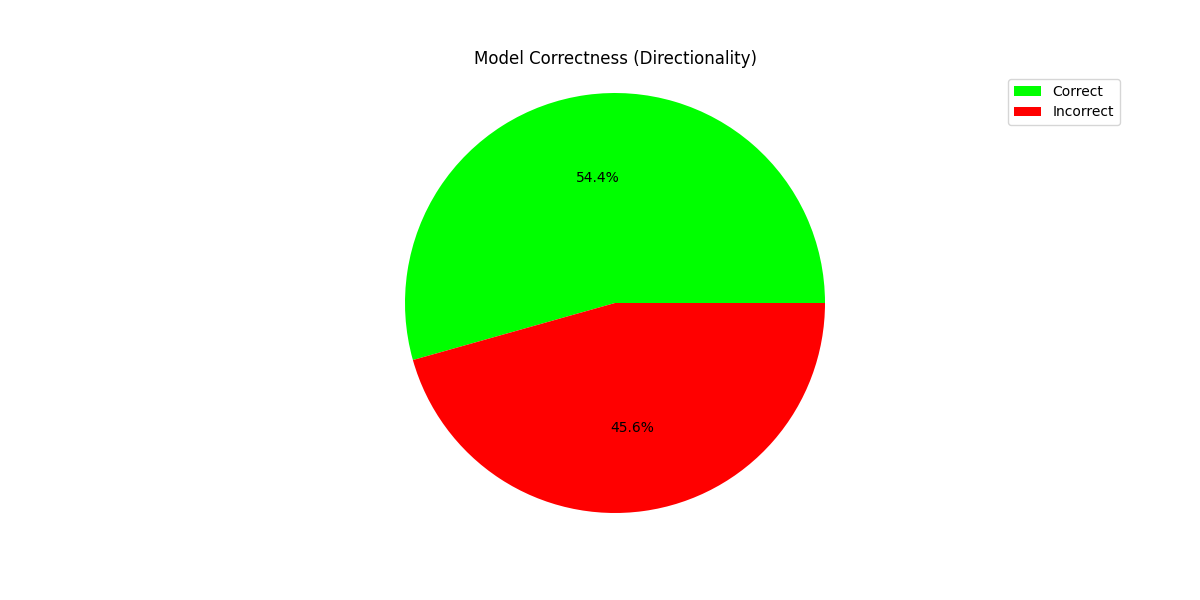

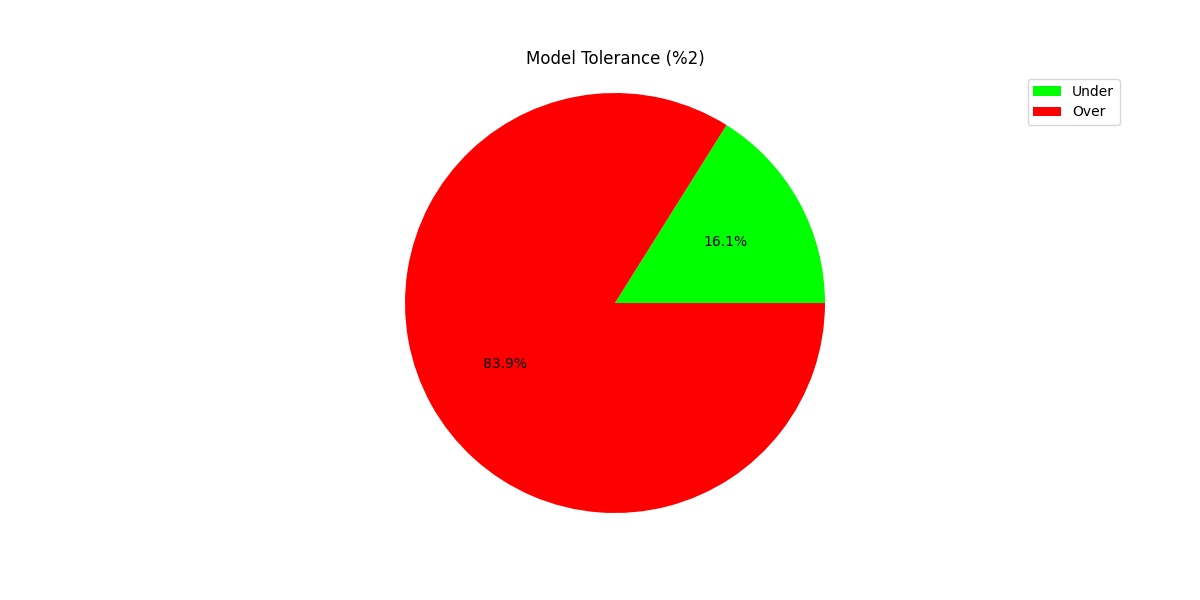

In [1312]:
plot_prediction_vs_gt(scaler, predicted_x_axis, ground_truth_x_axis, start_date, end_date, train_data_len, train_validation_split)
plot_daily_close(df_copy, ticker)
plot_daily_returns(df_copy, ticker)
plot_loss_chart(history)

(correct, incorrect, under, over, 
        correct_upwards_under, correct_upwards_over, correct_downwards_under, correct_downwards_over, 
        incorrect_upwards_under, incorrect_upwards_over, incorrect_downwards_under, incorrect_downwards_over
        ) = calculate_pie_chart_values(y_test_sw, predicted_values, tolerance_percent=tolerance_percent)

plot_pie_categories(
        tolerance_percent, 
        correct_upwards_under, correct_downwards_under, incorrect_upwards_under, incorrect_downwards_under, 
        correct_upwards_over, correct_downwards_over, incorrect_upwards_over, incorrect_downwards_over)
plot_pie_correctness(correct, incorrect)
plot_pie_tolerance(tolerance_percent, under, over)
